In [1]:
import os
import json
import hoomd
import codecs

import numpy as np

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render

from polykit.generators.initial_conformations import grow_cubic

In [2]:
# Generate uniform spherical distribution of 10,000 vertices by Gaussian sampling (https://mathworld.wolfram.com/SpherePointPicking.html)
number_of_vertices = 10000

vertex_positions = np.random.randn(number_of_vertices, 3)
vertex_positions /= np.linalg.norm(vertex_positions, axis=1, keepdims=True)

In [3]:
# Load vertices into HooMD snapshot
snapshot = build.get_simulation_box(box_length=2, pad=0.)

build.set_membrane_vertices(snapshot, vertex_positions)

In [4]:
# Rescale vertex diameters for easier visualization
vertex_rescale_factor = 0.01

snapshot.particles.diameter *= vertex_rescale_factor

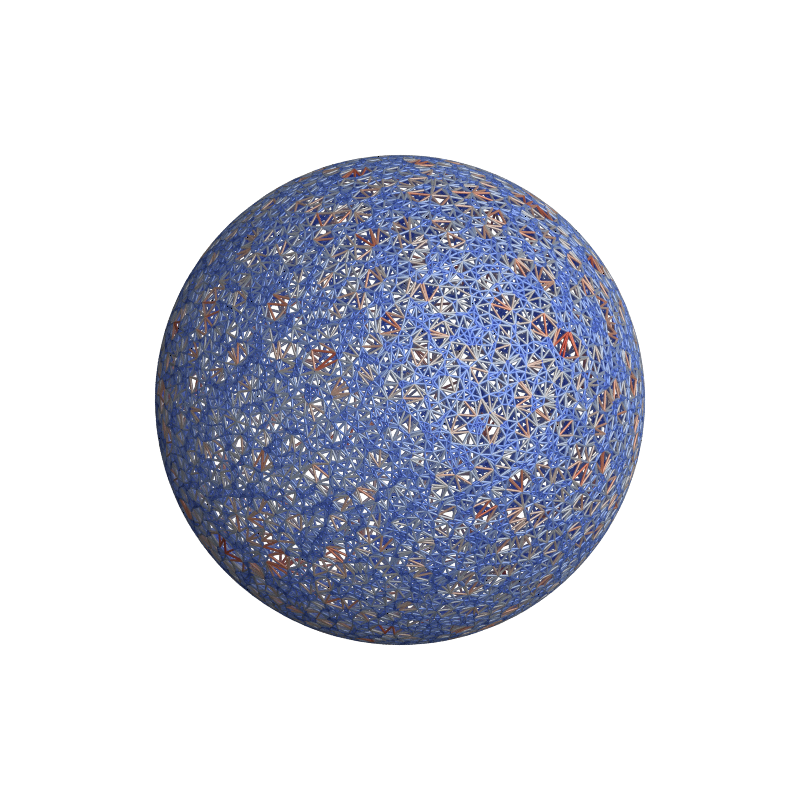

In [5]:
# Visualize the resulting mesh using Fresnel
render.fresnel(snapshot, outline=0, show='strains', cmap='coolwarm').static(height=800, width=800)

In [6]:
# That does not look very homogeneous! 
# Let's try to achieve a more regular mesh by solving the Thomson problem using HooMD (https://en.wikipedia.org/wiki/Thomson_problem)
vertex_positions_thomson = build.get_thomson_distribution(number_of_vertices)

HOOMD is running on the following GPU(s):
[0] NVIDIA A100-PCIE-40GB 108 SM_8.0 @ 1.41 GHz, 40339 MiB DRAM
Simulation.timestep  Simulation.tps     Status.etr    Thermo.potential_energy
       5000            471.78038      0:03:21.364881        4.94487e+07      
       10000           534.96092      0:02:48.236589        4.94483e+07      
       15000           559.11366      0:02:32.026334        4.94478e+07      
       20000           571.63156      0:02:19.950286        4.94477e+07      
       25000           579.27147      0:02:09.472975        4.94476e+07      
       30000           583.99599      0:01:59.863836        4.94476e+07      
       35000           587.20778      0:01:50.693356        4.94476e+07      
       40000           589.48490      0:01:41.783777        4.94475e+07      
       45000           591.35612      0:01:33.006562        4.94475e+07      
       50000           592.80068      0:01:24.345383        4.94475e+07      
       55000           593.95865    

In [7]:
# Load vertices into new HooMD snapshot
snapshot_thomson = build.get_simulation_box(box_length=2)

build.set_membrane_vertices(snapshot_thomson, vertex_positions_thomson)
snapshot_thomson.particles.diameter *= vertex_rescale_factor

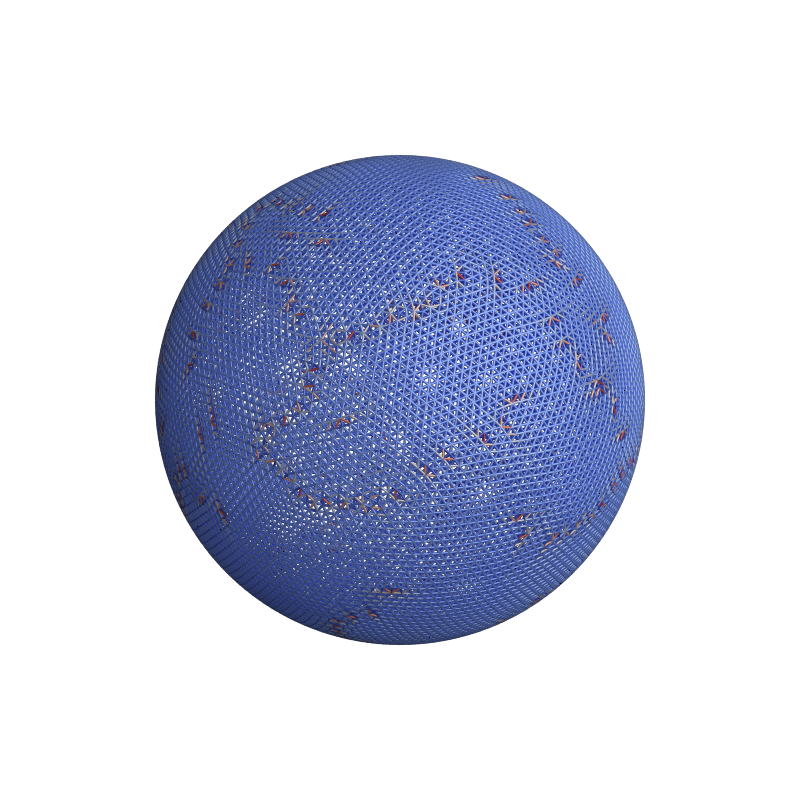

In [8]:
# That new mesh seems much better behaved! 
# Dislocation lines (scars) still necessarily remain, as imposed by Euler's formula (https://en.wikipedia.org/wiki/Euler_characteristic) 
render.fresnel(snapshot_thomson, outline=0, show='strains', cmap='coolwarm').static(height=800, width=800)

In [9]:
# Rescale membrane diameter such that the mean mesh edge length equals 1 (i.e., 50 nm in physical units)
# This yields a membrane radius of ~4 um
rescale_factor = np.sqrt(np.sqrt(3)*number_of_vertices/8*np.pi)

vertex_positions = vertex_positions_thomson * rescale_factor

In [10]:
# Load vertices into new HooMD snapshot
snapshot = build.get_simulation_box(box_length=2*rescale_factor)

build.set_membrane_vertices(snapshot, vertex_positions)

In [11]:
# Initialise HooMD on the CPU or GPU, based on availability
hoomd_device = build.get_hoomd_device()

HOOMD is running on the following GPU(s):
[0] NVIDIA A100-PCIE-40GB 108 SM_8.0 @ 1.41 GHz, 40339 MiB DRAM


In [12]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 3938


In [13]:
# Initialize simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [14]:
# Load vertices into simulation
snapshot = build.get_simulation_box(box_length=2*rescale_factor)

build.set_membrane_vertices(snapshot, vertex_positions)
system.create_state_from_snapshot(snapshot)

In [15]:
# At T=300K, these numbers yield a membrane Young's modulus of 25 mN/m and bending modulus of 3.5e−19 Nm (https://arxiv.org/pdf/2107.02598)
with open("force_dict_membrane.json", 'r') as dict_file:
    force_dict = json.load(dict_file)
    
print(json.dumps(force_dict, indent=4, sort_keys=True))

{
    "Bonded forces": {
        "Membrane": {
            "Rest length": 1.0,
            "Type": "Harmonic",
            "Wiggle distance": 0.01
        }
    },
    "Dihedral forces": {
        "Curvature": {
            "Stiffness": 100,
            "Type": "Harmonic"
        }
    },
    "Non-bonded forces": {
        "Repulsion": {
            "Cutoff": 1.0,
            "Matrix": {
                "Vertices": {
                    "Vertices": 100.0
                }
            },
            "Type": "Polychrom"
        }
    }
}


In [16]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.4, exclusions=['bond'])

In [17]:
# Set excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [18]:
# Set bonded/dihedral potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
dihedral_forces = forces.get_dihedral_forces(**force_dict)

/home1/tortora/.conda/envs/multistate/lib/python3.10/site-packages/hoomd/md/dihedral.py:131: FutureWarning: Harmonic is deprecated and will be removed in hoomd 4.0. Use Periodic instead.
  warnings.warn(


In [19]:
# Define elastic force field
relax_field = bonded_forces + dihedral_forces

In [20]:
# Relax mesh structure
nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
fire = hoomd.md.minimize.FIRE(dt=1e-4, methods=[nve], forces=relax_field,
                              force_tol=5e-2, angmom_tol=5e-2, energy_tol=5e-2)

/home1/tortora/.conda/envs/multistate/lib/python3.10/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [21]:
# Setup log and simulation engines
logger_relax = log.get_logger(system, quantities=['potential_energy'])

system.operations.integrator = fire
system.operations.writers.append(log.table_formatter(logger_relax, period=1e4))

In [22]:
# Run
system.run(2e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.potential_energy
       10000           7124.73306     0:00:26.667666        63768.62128      
       20000           8053.50371     0:00:22.350521        58094.23790      
       30000           8414.07374     0:00:20.204244        57061.19686      
       40000           8638.49396     0:00:18.521747        56605.36849      
       50000           8801.63052     0:00:17.042297        56449.96637      
       60000           8855.05611     0:00:15.810177        56364.14841      
       70000           8933.43133     0:00:14.552079        56296.55060      
       80000           8988.32346     0:00:13.350654        56249.85312      
       90000           9028.70428     0:00:12.183365        56194.94133      
      100000           9718.10130     0:00:10.290076        56192.36527      
      110000          10677.11169     0:00:08.429246        56192.36527      
      120000          11633.65734     0:00:06.876599        5619

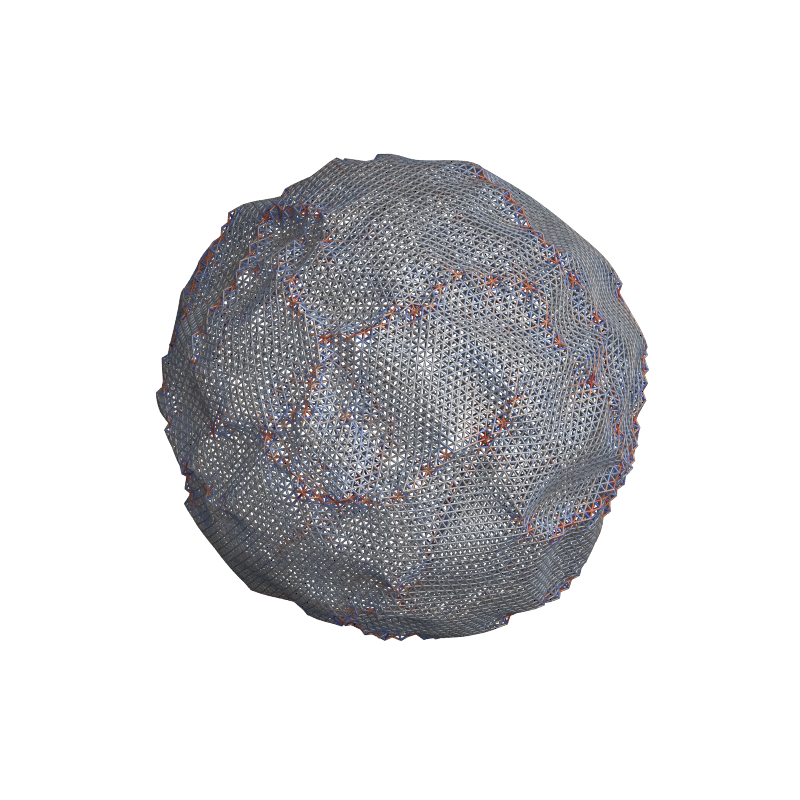

In [23]:
# Visualize relaxed mesh
snapshot_relaxed = system.state.get_snapshot()
render.fresnel(snapshot_relaxed, show='strains', cmap='coolwarm', outline=0, rescale_backbone_bonds=0.2).static(height=800, width=800)

In [24]:
# HooMD to openMM time conversion factor
t_conv = (1.67377*10**-27/(1.380649*10**-23*300))**0.5

In [25]:
# Set full force field
force_field = relax_field + repulsion_forces

In [26]:
# Unset relaxation engines
system.operations.remove(fire)
system.operations.remove(system.operations.writers[0])

In [27]:
# Initialize Langevin thermostat
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
integrator = hoomd.md.Integrator(dt=10*t_conv, methods=[langevin], forces=force_field)

In [28]:
# Update simulation engine
logger = log.get_logger(system)

system.operations.integrator = integrator
system.operations.writers.append(log.table_formatter(logger, period=5e4))

In [29]:
# Run
system.run(1e6)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
      250000           8748.66099     0:01:48.588046           1.00756          
      300000           9764.45364     0:01:32.171056           0.99433          
      350000          10157.57758     0:01:23.681369           1.01432          
      400000          10352.07908     0:01:17.279162           0.99271          
      450000          10483.41835     0:01:11.541550           1.00572          
      500000          10557.33482     0:01:06.304613           0.99914          
      550000          10621.10003     0:01:01.198934           0.99204          
      600000          10664.97769     0:00:56.258908           1.00377          
      650000          10705.28501     0:00:51.376493           1.00453          
      700000          10733.51139     0:00:46.583078           1.02016          
      750000          10759.06811     0:00:41.825184           0.99853          
      800000          10781.

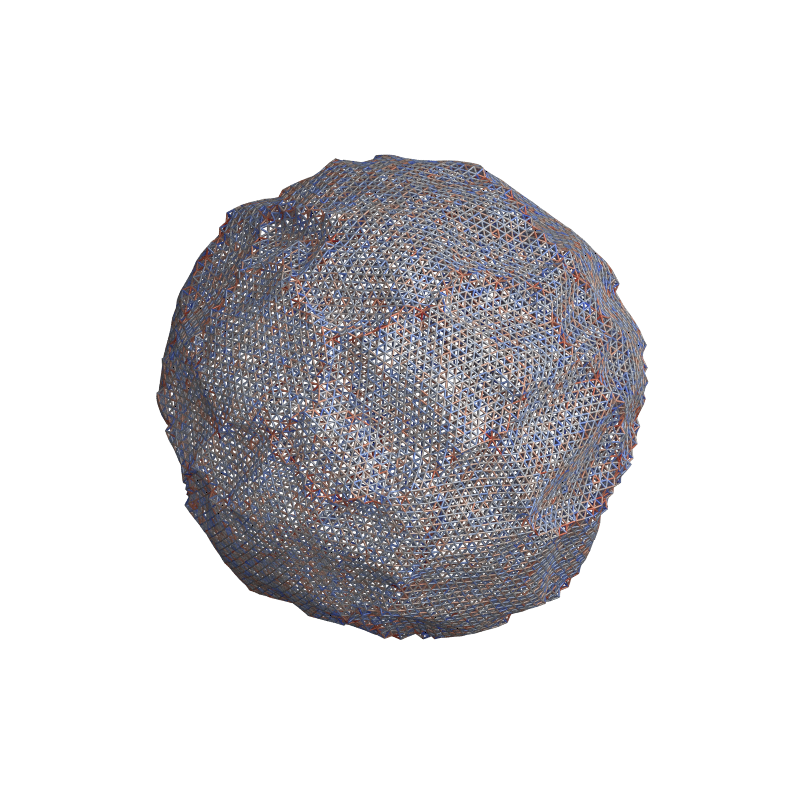

In [30]:
# Visualize thermalized membrane
snapshot_therm = system.state.get_snapshot()
render.fresnel(snapshot_therm, show='strains', cmap='coolwarm', outline=0, rescale_backbone_bonds=0.2).static(height=800, width=800)